In [6]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark import SparkContext,SparkConf
import csv
from itertools import combinations
from collections import OrderedDict,Counter
import random
from numpy.random import rand
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
def emit_idx_rating(lines,uid2idx_bc, bid2idx_bc):
    for line in lines:
        yield Rating(uid2idx_bc.value[line[0]],bid2idx_bc.value[line[1]],line[2])

def emit_idx_rating_test(lines,uid2idx_bc, bid2idx_bc):
    for line in lines:
        if line[0] in uid2idx_bc.value.keys():
            if line[1] in bid2idx_bc.value.keys():
                yield Rating(uid2idx_bc.value[line[0]],bid2idx_bc.value[line[1]],line[2])

def emit_missing_pairs(lines, uid2idx_bc, bid2idx_bc):
    for line in lines:
        if line[0] in uid2idx_bc.value.keys() and line[1] not in bid2idx_bc.value.keys():
            yield [uid2idx_bc.value[line[0]], line[1],line[2]]
        elif line[0] not in uid2idx_bc.value.keys() and line[1] in bid2idx_bc.value.keys():
            yield [line[0], bid2idx_bc.value[line[1]],line[2]]

In [2]:
experiment_file = "./task2_experiment.txt"
conf = SparkConf().set('spark.driver.host','127.0.0.1')
sc = SparkContext(master='local', appName='myAppName',conf=conf)
experimient = sc.textFile(experiment_file)
header = experimient.first()

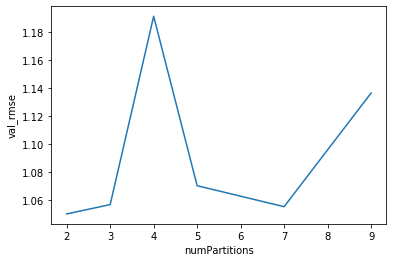

In [3]:
# 0:rank, 1:lambda, 2:numIter, 3:numPartitions, 4:train_RMSE, 5:val_RMSE, 6:duration
clean_log = experimient.filter(lambda x: x != header).map(lambda x: x.strip().split()).map(lambda x:[int(x[0]), float(x[1]), int(x[2]), int(x[3]), float(x[4]), float(x[5]), int(x[6])])
r2_lmbda0_2_iter15 = clean_log.filter(lambda x: x[0]==2 and x[1]==0.2 and x[2]==15).map(lambda x: [x[3],x[4],x[5]]).collect()
val_rmse = []
train_rmse = []
numP = []
for line in r2_lmbda0_2_iter15:
    numP.append(line[0])
    train_rmse.append(line[1])
    val_rmse.append(line[2])
df = pd.DataFrame({"numPartitions":numP, "train_rmse":train_rmse, "val_rmse":val_rmse})
sns.lineplot(x="numPartitions", y="val_rmse",data=df)

In [7]:
data = np.array(clean_log.collect())
log_data_df = pd.DataFrame(data=data,columns=["rank", "lambda", "numIter", "numPartitions", "train_RMSE", "val_RMSE", "duration"])

In [10]:
log_data_df["numPartitions"] = log_data_df["numPartitions"].astype(int)
log_data_df["rank"] = log_data_df["rank"].astype(int)
log_data_df["numIter"] = log_data_df["numIter"].astype(int)

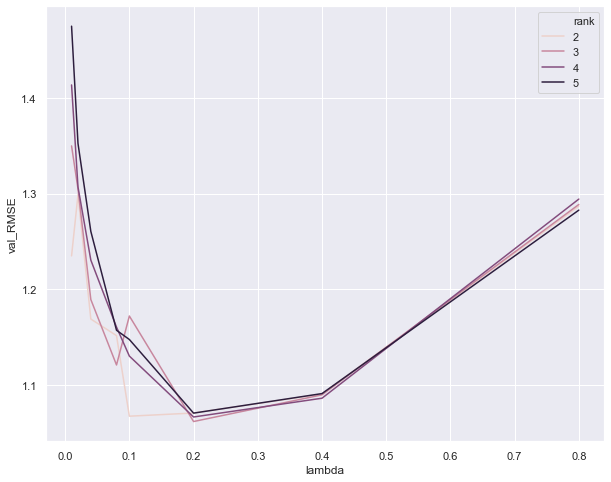

In [26]:
sns.set(rc={'figure.figsize':(10,8)})
tmp = log_data_df[log_data_df["numPartitions"]==5]
tmp2 = tmp[tmp["rank"]<6]
sns.lineplot(x='lambda',y='val_RMSE',hue='rank',data=tmp2[tmp2["numIter"]==15])

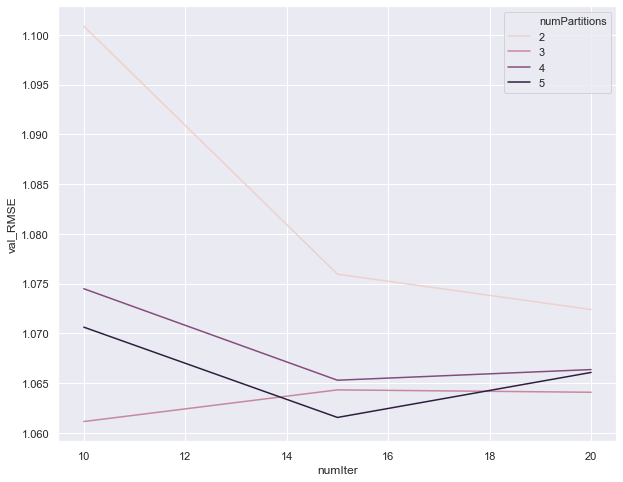

In [34]:
sns.set(rc={'figure.figsize':(10,8)})
tmp = log_data_df[log_data_df["lambda"]==0.2]
tmp2 = tmp[tmp['numPartitions']<6]
sns.lineplot(x='numIter',y='val_RMSE',hue='numPartitions',data=tmp2[tmp2["rank"]==3])

In [4]:

train_file = "/Users/liangsiqi/Documents/Dataset/yelp_rec_data/yelp_train.csv"
val_file = "/Users/liangsiqi/Documents/Dataset/yelp_rec_data/yelp_val.csv"


raw_train = []
with open(train_file, 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            raw_train.append([row[0],row[1],float(row[2])])

raw_val = []
with open(val_file, 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            raw_val.append([row[0],row[1],float(row[2])])

print("train data size: ", len(raw_train))
print("validation data size: ", len(raw_val))

# numPartitions = 4
# [user_id, business_id, stars]
# sc = SparkContext.getOrCreate()
train_data = sc.parallelize(raw_train,5)
val_data = sc.parallelize(raw_val,5)


avg_train = train_data.map(lambda x: x[2]).mean()


user_ids = train_data.map(lambda x: x[0]).distinct().collect()
user_cnt = len(user_ids)
business_ids = train_data.map(lambda x: x[1]).distinct().collect()
business_cnt = len(business_ids)

uid2idx = dict()
bid2idx = dict()
idx2bid = dict()
for idx, uid in enumerate(user_ids, 0):
    uid2idx[uid] = idx

for idx, bid in enumerate(business_ids, 0):
    bid2idx[bid] = idx
    idx2bid[idx] = bid

idx2bid_bc = sc.broadcast(idx2bid)
uid2idx_bc = sc.broadcast(uid2idx)
bid2idx_bc = sc.broadcast(bid2idx)

train data size:  455854
validation data size:  142044


In [6]:
train_ratings = train_data.mapPartitions(lambda lines: emit_idx_rating(lines,uid2idx_bc, bid2idx_bc))
# val_ratings = val_data.mapPartitions(lambda lines: emit_idx_rating_test(lines,uid2idx_bc, bid2idx_bc))

# uid_miss_num = val_ratings.filter(lambda x: x[0]==-1 and x[1]!=-1).count()
# bid_miss_num = val_ratings.filter(lambda x: x[0]!=-1 and x[1]==-1).count()
# both_id_miss_num = val_ratings.filter(lambda x: x[0]==-1 and x[1]==-1).count()
# print("Number of missing uid, while bid exists: ", uid_miss_num)
# print("Number of missing bid, while uid exists: ", bid_miss_num)
# print("Number of missing both bid and uid: ", both_id_miss_num)

In [7]:
# Build the recommendation model using Alternating Least Squares
ranks = [2,3,4,5,6,7,8,10]
lambdas = [0.001, 0.1, 1]
numIters = [10,15,20]

model = ALS.train(train_ratings, 3, 15,0.1)

In [8]:
# Evaluate the model on training data
testdata = train_ratings.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = train_ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
RMSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()**0.5
print("train RMSE = " + str(RMSE))

train RMSE = 0.8158316135068885


In [11]:
res = model.predictAll(testdata).take(1)[0]
res[0],res[1],res[2],res

(846,
 18624,
 3.931981344155509,
 Rating(user=846, product=18624, rating=3.931981344155509))

In [8]:
# Evaluate the model on validation data
valdata = val_ratings.map(lambda p: (p[0], p[1]))
val_predictions = model.predictAll(valdata).map(lambda r: ((r[0], r[1]), r[2]))
val_ratesAndPreds = val_ratings.map(lambda r: ((r[0], r[1]), r[2])).join(val_predictions)
err_sqare_sum1 = val_ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).sum()
print("validation RMSE = " + str(RMSE))

validation RMSE = 1.1380954567893296


NameError: name 'valdata' is not defined

In [12]:
val_missing_record = val_data.mapPartitions(lambda lines: emit_missing_pairs(lines, uid2idx_bc, bid2idx_bc))
train_ratings.take(1), val_missing_record.take(1)

([Rating(user=8969, product=9857, rating=5.0)],
 [[1752, 'yFumR3CWzpfvTH2FCthvVw', 3.0]])

In [25]:
def ff():
    scores = []
    for rating in filter(lambda x: x.user==1752,train_ratings.collect()):
        scores.append(rating.rating)

%timeit ff()
%timeit train_ratings.filter(lambda x: x.user==1752).map(lambda x: x.rating).collect()

1.5 s ± 93.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
777 ms ± 8.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
ranks = [2, 3, 4, 5, 6, 7]
lambdas = [0.01, 0.02, 0.04, 0.08, 0.1, 0.2, 0.4, 0.7]
numIters = [10, 15, 20]
partition_num = [2, 3, 4, 5, 6, 7, 8]
print(len(ranks)*len(lambdas)*len(numIters)*len(partition_num))

1008


In [27]:
val_missing_record = val_missing_record.collect()

In [35]:
val_missing_predict = []
train_ratings.persist()
for record in val_missing_record:
    if isinstance(record[0], int):
        if isinstance(record[1], int):
            pass
        else:
            rating = train_ratings.filter(lambda x: x.user==record[0]).map(lambda x: x.rating).mean()
            val_missing_predict.append([record[0],record[1],rating])
    else:
        if isinstance(record[1], int):
            rating = train_ratings.filter(lambda x: x.product==record[1]).map(lambda x: x.rating).mean()
            val_missing_predict.append([record[0],record[1],rating])

In [15]:
%timeit train_ratings.filter(lambda x: x.user==1752).map(lambda x: x.rating).collect()

[1.0,
 5.0,
 5.0,
 3.0,
 3.0,
 2.0,
 4.0,
 4.0,
 3.0,
 5.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 4.0,
 5.0,
 4.0,
 3.0,
 1.0,
 5.0,
 4.0,
 4.0,
 4.0]

In [32]:
train_ratings.filter(lambda x: x.user==1752).take(1)

[Rating(user=1752, product=21387, rating=1.0)]